### Spatial variation of house effect
Previously I fitted a Poisson mixed effect model with village and month as fixed effects as well as mosquito nets and number of residents. The random effects are observational-level overdispersion, yearly and among-house variations. Some analyses were run only on the wet season counts (response is the female count, both species combined). 

To further investigate the house effect and its spatial clustering (if any) I wanted to fit a similar model by changing it to a fixed effect with about 300 levels (houses). This also meant to estimate 300 additional parameters for each house rather than one overall variance estimate. The computer did not like this task and I was stuck. 

After some research I discovered a method to extract the approximate house effect from the existing mixed effect model. I am still reading about this. Since the house effect is the difference between the house mean and the overall mean (after controlling for other factors), it is possible to work it back by comparing the fitted and observed data points. Hence R calls it the "conditional mode". 

I think it is a good middle ground for our task. Again I will work on the wet season count for the moment. 

In [1]:
# LOAD R PACKAGES
require(compiler)
enableJIT(3)
setMKLthreads(23)
require(lme4)
require(lmerTest)
require(MASS)

# LOAD DATASET dat1
#setwd('variance/Florian')
load('Per house data PSC 2012 to 2019 polish2.RData')
load('BF_weather.RData')
ls()

Loading required package: compiler


[1] 3

Loading required package: lme4
Loading required package: Matrix
Loading required package: lmerTest

Attaching package: 'lmerTest'

The following object is masked from 'package:lme4':

    lmer

The following object is masked from 'package:stats':

    step

Loading required package: MASS


[1] "BV_weather" "dat1"       "PL_weather" "SK_weather"

In [2]:
names(dat1)
names(BV_weather)

[1] "village"            "month.assigned"     "year.assigned"     
 [4] "monthyear.assigned" "day"                "month"             
 [7] "year"               "date.collection"    "site.id"           
[10] "longitude"          "latitude"           "room.id"           
[13] "num.persons"        "num.persons.remark" "mosquito.net"      
[16] "permanence"         "count.m"            "genotyped.m"       
[19] "col.m"              "gam.m"              "arab.m"            
[22] "count.f"            "genotyped.f"        "col.f"             
[25] "gam.f"              "arab.f"

[1] "date"             "meantemp.c"       "maxtemp.c"        "mintemp.c"       
 [5] "humidity.percent" "winddir.deg"      "windspeed.kmhr"   "gustspeed.kmhr"  
 [9] "rain.mm"          "sun.wma2"

In [3]:
# SUBSET (MAY-OCTOBER ONLY)
dat1<-dat1[dat1$month.assigned %in% 5:10,]
# dat1 GOT OVER-WRITTEN SO YOU NEED TO BE CAREFUL. 
dim(dat1)

[1] 1626   26

In [4]:
# THREE LEVELS OF PERSONS: None, Low, Hi
dat1$persons.status<-dat1$num.persons
dat1$persons.status[dat1$num.persons>3]<-'Hi'
dat1$persons.status[dat1$num.persons<=3]<-'Low'
dat1$persons.status[dat1$num.persons==0]<-'None'
dat1$persons.status<-factor(dat1$persons.status, levels=c('None', 'Low', 'Hi'))
overdispersion<-1:nrow(dat1)

In [5]:
m_4C<-glmer(count.f~(1|year.assigned)+(1|site.id)+(1|overdispersion)+month.assigned*village+mosquito.net+persons.status, 
             family='poisson', data=dat1, 
             control=glmerControl(optimizer="bobyqa", optCtrl=list(maxfun=3e4)))
#m_4C<-glmer(count.f~(1|year.assigned)+(1|site.id)+(1|overdispersion)+month.assigned*village+mosquito.net+persons.status, 
#             family='poisson', data=dat1, 
#             control=glmerControl(optimizer="bobyqa"))
summary(m_4C)


Correlation matrix not shown by default, as p = 27 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: 
count.f ~ (1 | year.assigned) + (1 | site.id) + (1 | overdispersion) +  
    month.assigned * village + mosquito.net + persons.status
   Data: dat1
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 30000))

     AIC      BIC   logLik deviance df.resid 
 11207.0  11367.9  -5573.5  11147.0     1551 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.39317 -0.32426 -0.01092  0.12816  0.58715 

Random effects:
 Groups         Name        Variance Std.Dev.
 overdispersion (Intercept) 1.2350   1.1113  
 site.id        (Intercept) 0.4070   0.6380  
 year.assigned  (Intercept) 0.1096   0.3311  
Number of obs: 1581, groups:  
overdispersion, 1581; site.id, 278; year.assigned, 6

Fixed effects:
                                        Estimate Std. Error z value Pr(>|z|)
(Intercept)                              1.22601    0.56217   2

In [6]:
# PUT ESTIMATED RANDOM EFFECTS INTO A DATA FRAME
s<-ranef(m_4C)$site.id
site.id.effect<-data.frame(site.id=rownames(s), effect=unlist(s), row.names=NULL)
nrow(site.id.effect)
#hist(site.id.effect$effect)
#head(site.id.effect)

# EXTRACT LAT LONG INFO (MANY DUPLICATED)
s1<-dat1[!duplicated(dat1[,c(1,9:11)]), c(1,9:11)]
nrow(s1)

# MERGE LAT AND LONG
s2<-merge(site.id.effect, s1, by='site.id', all.x=T)
dim(s2)
head(s2)
rm(s); rm(s1);

[1] 278

[1] 284

[1] 278   5

site.id,effect,village,longitude,latitude
BF.BM.02.001,0.01698915,Bana market,-4.471190,11.23421
BF.BM.03.001,-0.44719364,Bana market,-4.471004,11.23479
BF.BM.121.001,1.22519805,Bana market,-4.472744,11.23510
BF.BM.13.001,0.75194327,Bana market,-4.470798,11.23368
BF.BM.16.001,-0.27463114,Bana market,-4.482247,11.24220
BF.BM.26.001,0.12425372,Bana market,-4.484353,11.24241


#### Extracting "conditional mode" for each house
The function ranef() extracts the "conditional mode" for individual house effect. it also returns overdispersion and yearly effect as well but they are not our focus. I then append these estimates with coordinates info. 

Below I plot the histrogram of these house effect and it certainly looks like a bell curve. It is because the mixed effect model assumes normality on the random components (and if I fit it as a fixed effect then no assumption is made on these 300 house levels). I believe I am still able to preserve the order and relative strengh of the house effect. 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-1.051531 -0.273587  0.000346  0.006330  0.251589  1.302861 

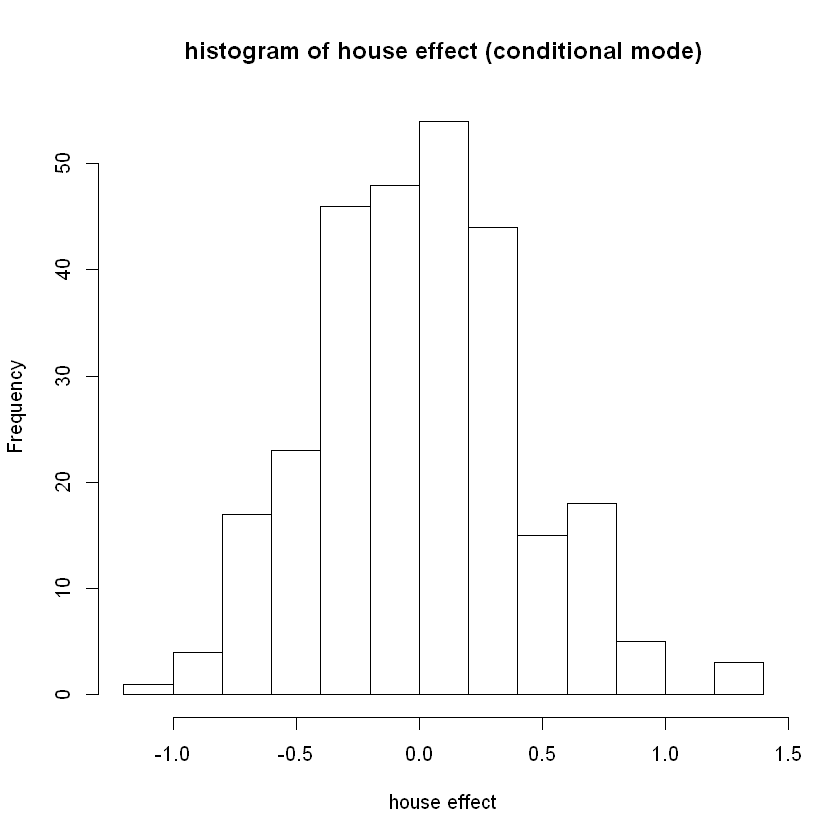

In [7]:
hist(s2$effect, xlab='house effect', main='histogram of house effect (conditional mode)')
# OVERALL SUMMARY ON HOUSE EFFECT
summary(s2$effect)

In [8]:
# HOUSE EFFECT PER VILLAGE, ALL SHOULD HAVE SIMILAR MEAN (IF THE VILLAGE EFFECT IS PROPERLY HANDLED BY THE MAIN FIXED EFFECT)
by(s2$effect, list(s2$village), FUN=summary)

: Bana market
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.447194 -0.304189 -0.197098 -0.001108  0.059941  1.225198 
------------------------------------------------------------ 
: Bana village
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-1.051531 -0.347435  0.004643 -0.004638  0.273471  1.297685 
------------------------------------------------------------ 
: Pala
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.850350 -0.229464 -0.009336  0.011439  0.253926  0.833349 
------------------------------------------------------------ 
: Souroukoudingan
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.86164 -0.24900  0.03665  0.01294  0.24133  1.30286 

#### Heatmap
After studying the summary of the house effect I decide to assign them into 51 bins (for colouring) with equal width of 0.05. A heatmap (and some zoom-ins) is produced. Each dot is a house, and the more red the higher effect the house has. 

In [38]:
bounds<-seq(-1.15, 1.35, 0.05)
length(bounds)
# ASSIGN EFFECTS INTO BINS
# PUT EFFECTS INTO BINS
bins<-cut(s2$effect, breaks=bounds, labels=F)
# LARGE EFFECT SMALL BINS NUMBER AND MORE RED
bins<-length(bounds)-bins
#bins
bins[57]
s2$effect[57]

[1] 51

[1] 49

[1] -1.051531

In [42]:
# RANK THE HOUSE EFFECT IN DESCENDING ORDER AND ASSIGN COLOUR CODE (LARGE IS RED)
colour_map<-heat.colors(length(bounds))
s2$col<-colour_map[bins]
rm(bins); rm(bounds);

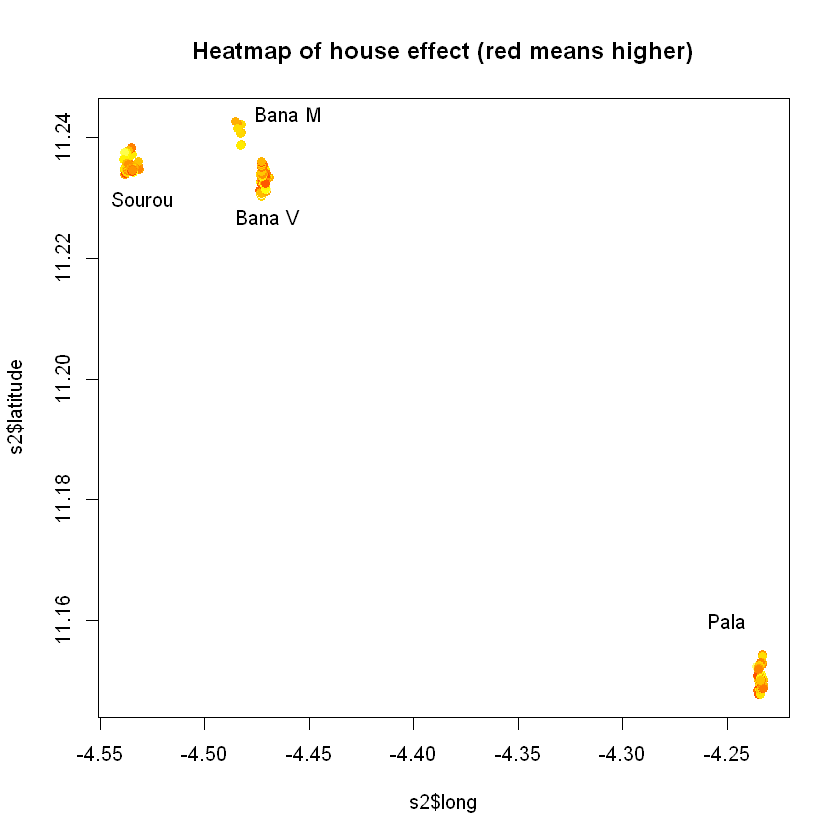

In [43]:
# TOPRIGHT IS SOUROU, THEN BANA M, BANA V, BOTTOM IS PALA
# ACCORDING TO GOOGLE MAP
plot(x=s2$long, y=s2$latitude, pch=16, col=s2$col, 
    main='Heatmap of house effect (red means higher)')
text(-4.53, 11.23, 'Sourou')
text(-4.46, 11.244, 'Bana M')
text(-4.47, 11.227, 'Bana V')
text(-4.25, 11.16, 'Pala')

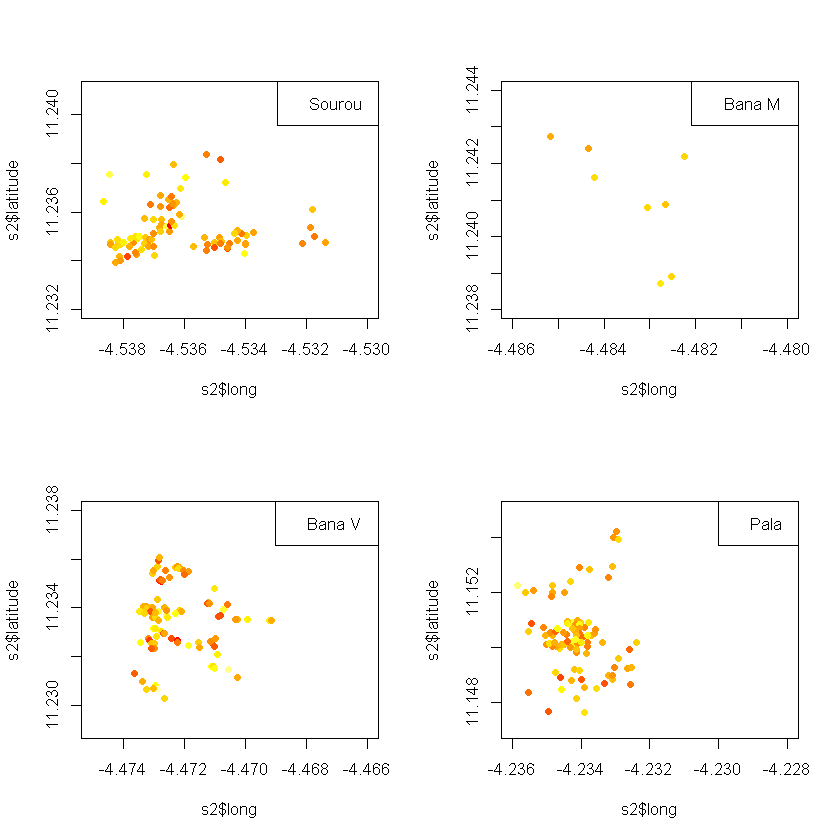

In [44]:
# ZOOM IN
par(mfrow=c(2,2))
#
plot(x=s2$long, y=s2$latitude, 
     xlim=c(-4.539, -4.539+0.009), ylim=c(11.232,11.232+0.009),
     pch=16, col=s2$col)
legend('topright', legend='Sourou')
#
plot(x=s2$long, y=s2$latitude, 
     xlim=c(-4.486, -4.486+0.006), ylim=c(11.238,11.238+0.006),
     pch=16, col=s2$col)
legend('topright', legend='Bana M')
# 
plot(x=s2$long, y=s2$latitude, 
     xlim=c(-4.475, -4.475+0.009), ylim=c(11.229,11.229+0.009),
     pch=16, col=s2$col)
legend('topright', legend='Bana V')
#
plot(x=s2$long, y=s2$latitude, 
     xlim=c(-4.236, -4.236+0.008), ylim=c(11.147, 11.147+0.008),
     pch=16, col=s2$col)
legend('topright', legend='Pala')


#### To be continued